In [20]:
import math
from argparse import ArgumentTypeError

import numpy as np
from sklearn.neighbors import KDTree


class KNNClassifier:
    y = None
    X = None
    y_set = None
    
    def __init__(self, n_neighbors=5, metric='minkowski', p=2, kernel='uniform', h=None, class_weights=None, prior_weights=None, a=2, b=1, alpha=0.75):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.p = p 
        self.kernel = kernel
        self.h = h 
        self.class_weights = class_weights
        self.prior_weights = prior_weights 
        self.a = a 
        self.b = b
        self.alpha = alpha
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.y_set = set(y)
    
    def predict(self, X):
        prediction = []
        
        rho = self.__choose_metric__()
        k = self.__choose_kernel__()
        
        for obj in X:
            if self.h is not None:
                radius = self.h 
            else:
                radius = self.__compute_radius__(obj, rho)
                
            mx = 0
            pred = None
            for y_i in self.y_set:
                sum = 0
                for i in range(len(self.X)):
                    dist = rho(obj, self.X[i]) / radius
                    if self.prior_weights is not None:
                        weight = self.prior_weights[i]
                        if self.__uniform_kernel__(dist) == 0:
                            weight = 0
                    else:
                        weight = k(dist)
                        if self.class_weights is not None:
                            weight *= self.class_weights[y_i]
                    sum += int(self.y[i] == y_i) * weight
                if sum > mx:
                    mx = sum 
                    pred = y_i
            
            if pred is None:
                pred = np.random.choice(list(self.y_set))
            prediction.append(pred)
        
        return prediction
    
    def score(self, X, y):
        prediction = self.predict(X)
        correct = 0
        for i in range(len(y)):
            correct += prediction[i] == y[i]
        return correct / len(y)
            
    def __compute_radius__(self, obj, rho):
        distances = []
        for neighbor in self.X:
            distances.append(rho(neighbor, obj))
        distances.sort()
            
        radius = distances[self.n_neighbors] + 0.001
        return radius
        
            
    def __choose_kernel__(self):
        if callable(self.kernel):
            return self.kernel
        elif self.kernel == 'uniform':
            return lambda x: self.__uniform_kernel__(x)
        elif self.kernel == 'triangular':
            return lambda x: self.__triangular_kernel__(x)
        elif self.kernel == 'epanechnikov':
            return lambda x: self.__epanechnikov_kernel__(x)
        elif self.kernel == 'gaussian':
            return lambda x: self.__gaussian_kernel__(x)
        elif self.kernel == 'general':
            if self.a is not None and self.b is not None and self.alpha is not None:
                return lambda x: self.__general_kernel__(x, self.a, self.b, self.alpha)
            raise AttributeError('Some of general kernel\'s are not implemented yet')
    
    def __choose_metric__(self):
        if callable(self.metric): 
            return self.metric
        elif self.metric == 'minkowski':
            if self.p is not None:
                return lambda x, y: self.__minkowski_distance__(x, y, p=self.p)
            raise AttributeError('p should not be None at Minkowski distance')
        elif self.metric == 'euclidean':
            return lambda x, y: self.__minkowski_distance__(x, y, p=2)
        elif self.metric == 'chebyshev': 
            return lambda x, y: self.__chebyshev_distance__(x, y)
        elif self.metric == 'cosine':
            return lambda x, y: self.__cosine_distance__(x, y)
        else:
            raise AttributeError('Unknown metric')
    
    
    @staticmethod
    def __minkowski_distance__(x, y, p):
        if len(x) != len(y):
            raise ArgumentTypeError('x and y must have the same length')
        sum = 0
        for i in range(len(x)):
            sum += (x[i] - y[i]) ** p
        return sum ** (1 / p)


    @staticmethod
    def __chebyshev_distance__(x, y):
        if len(x) != len(y):
            raise ArgumentTypeError('x and y must have same length')
        mx = 0
        for i in range(len(x)):
            mx = max(mx, abs(x[i] - y[i]))
        return mx 
    
    @staticmethod
    def __cosine_distance__(x, y):
        if len(x) != len(y):
            raise ArgumentTypeError('x and y must have the same length')
        sum1 = 0
        sum2 = 0
        sum3 = 0
        for i in range(len(x)):
            sum1 += x[i] * y[i]
            sum2 += x[i] ** 2 
            sum3 += y[i] ** 2
        return 1 - sum1 / (sum2 ** 0.5 * sum3 ** 0.5)

    @staticmethod
    def __uniform_kernel__(u):
        if u <= -1 or u >= 1:
            return 0
        return 0.5  
    
    @staticmethod
    def __triangular_kernel__(u):
        if u <= -1 or u >= 1:
            return 0
        return 1 - abs(u)
    
    @staticmethod
    def __epanechnikov_kernel__(u):
        if u <= -1 or u >= 1:
            return 0
        return 0.75 * (1 - u ** 2)
    
    @staticmethod
    def __gaussian_kernel__(u):
        return 1 / (math.sqrt(2 * math.pi)) * math.exp((-u ** 2) / 2)
    
    @staticmethod
    def __general_kernel__(u, a, b, alpha):
        if u <= -1 or u >= 1:
            return 0
        return alpha * (1 - abs(u) ** a) ** b
        

In [2]:
import pandas as pd

df = pd.read_csv("features_30_sec.csv")

df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [3]:
set(df['label'])

{'blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock'}

In [4]:
df = df.drop(['filename', 'length'], axis=1)

In [5]:
df.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [6]:
labels = df['label']

df = df.drop(['label'], axis=1)
df = (df - df.mean()) / df.std()

df['genre'] = labels

df.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,genre
0,-0.349962,0.312431,-0.010684,-0.061825,-0.583293,-0.847887,-0.456174,-0.530776,-0.486229,-0.661603,...,-0.245991,0.500212,-0.779875,-0.236922,-0.642855,0.006720,-0.300447,0.603762,-0.512731,blues
1,-0.462250,1.117013,-0.532586,-0.186727,-0.938046,-0.234077,-0.386658,0.795854,-0.648357,0.795425,...,-0.159095,0.711015,-0.069270,-0.054954,-0.453229,0.544533,-0.406883,0.423915,-0.538152,blues
2,-0.184132,-0.137632,0.679638,-0.084051,-0.906431,-0.781303,-0.940192,-0.630600,-0.971106,-0.744033,...,-0.595945,-0.827102,-0.447866,-0.600682,-0.329354,-0.295786,-0.527033,-0.296041,-0.874516,blues
3,0.319479,0.990164,0.154732,0.906575,-1.580638,-0.711739,-1.227642,0.304413,-1.515631,-0.246407,...,-0.482601,0.142082,-0.371185,0.033410,-0.767208,0.455181,-0.779354,-0.602579,-0.844086,blues
4,-0.858647,0.194066,-0.599865,-0.205806,-0.512286,-0.315021,-0.939300,-0.504210,-0.629792,-0.190422,...,0.750942,-0.327056,0.377431,-0.368191,-0.293549,-0.552740,-0.089338,-2.764625,-0.330122,blues


In [7]:
from sklearn.model_selection import train_test_split

X = df.drop('genre', axis=1)
y = df['genre']

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25, random_state=19)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=19)

print(X_train.shape, X_val.shape, X_test.shape)

(600, 57) (150, 57) (250, 57)


In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

print(knn.score(X_test, y_test))

0.62


In [61]:
import optuna

def objective(trial):
    k = trial.suggest_int('k', 1, 100)
    knn = KNeighborsClassifier(n_neighbors=k)
    
    knn.fit(X_train, y_train)
    
    accuracy = knn.score(X_val, y_val)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
study.best_params

[I 2024-03-10 19:15:19,604] A new study created in memory with name: no-name-073ac974-7b9b-420f-92a8-c5480e7324ab
[I 2024-03-10 19:15:19,614] Trial 0 finished with value: 0.6 and parameters: {'k': 25}. Best is trial 0 with value: 0.6.
[I 2024-03-10 19:15:19,623] Trial 1 finished with value: 0.48 and parameters: {'k': 89}. Best is trial 0 with value: 0.6.
[I 2024-03-10 19:15:19,632] Trial 2 finished with value: 0.47333333333333333 and parameters: {'k': 58}. Best is trial 0 with value: 0.6.
[I 2024-03-10 19:15:19,640] Trial 3 finished with value: 0.5 and parameters: {'k': 52}. Best is trial 0 with value: 0.6.
[I 2024-03-10 19:15:19,649] Trial 4 finished with value: 0.4666666666666667 and parameters: {'k': 68}. Best is trial 0 with value: 0.6.
[I 2024-03-10 19:15:19,658] Trial 5 finished with value: 0.5466666666666666 and parameters: {'k': 43}. Best is trial 0 with value: 0.6.
[I 2024-03-10 19:15:19,667] Trial 6 finished with value: 0.6333333333333333 and parameters: {'k': 1}. Best is tri

{'k': 3}

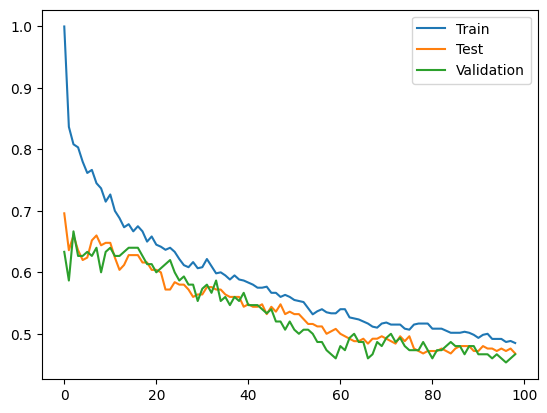

In [25]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

train_accuracies = []
test_accuracies = []
val_accuracies = []

for k in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracies.append(knn.score(X_train, y_train))
    test_accuracies.append(knn.score(X_test, y_test))
    val_accuracies.append(knn.score(X_val, y_val))
    
    clear_output(True)
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.plot(val_accuracies, label='Validation')
    plt.legend()
    plt.show()
    

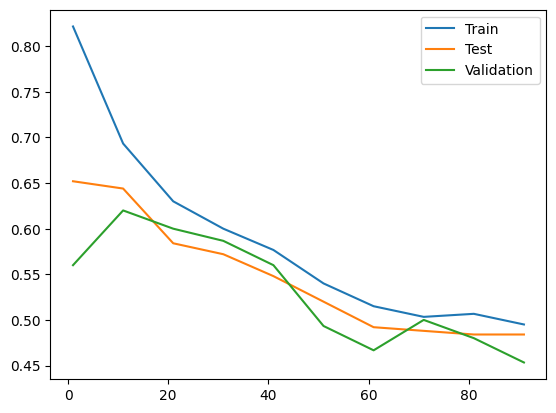

In [60]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

train_accuracies = []
test_accuracies = []
val_accuracies = []
n_neighbors = []

for k in range(1, 100, 10):
    knn = KNNClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracies.append(knn.score(X_train, y_train))
    test_accuracies.append(knn.score(X_test, y_test))
    val_accuracies.append(knn.score(X_val, y_val))
    n_neighbors.append(k)
    
    clear_output(True)
    plt.plot(n_neighbors, train_accuracies, label='Train')
    plt.plot(n_neighbors, test_accuracies, label='Test')
    plt.plot(n_neighbors, val_accuracies, label='Validation')
    plt.legend()
    plt.show()
    

In [62]:
import optuna

def objective(trial):
    k = trial.suggest_int('k', 1, 100, log=True)
    knn = KNNClassifier(n_neighbors=k)
    
    knn.fit(X_train, y_train)
    
    accuracy = knn.score(X_val, y_val)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
study.best_params

[I 2024-03-10 19:15:44,784] A new study created in memory with name: no-name-e1df8b95-36c0-454f-8f53-cc9d2a2132cc
[I 2024-03-10 19:16:05,795] Trial 0 finished with value: 0.56 and parameters: {'k': 1}. Best is trial 0 with value: 0.56.
[I 2024-03-10 19:16:26,789] Trial 1 finished with value: 0.5 and parameters: {'k': 53}. Best is trial 0 with value: 0.56.
[I 2024-03-10 19:16:48,089] Trial 2 finished with value: 0.56 and parameters: {'k': 1}. Best is trial 0 with value: 0.56.
[I 2024-03-10 19:17:09,434] Trial 3 finished with value: 0.5733333333333334 and parameters: {'k': 28}. Best is trial 3 with value: 0.5733333333333334.
[I 2024-03-10 19:17:30,114] Trial 4 finished with value: 0.56 and parameters: {'k': 1}. Best is trial 3 with value: 0.5733333333333334.
[I 2024-03-10 19:17:50,678] Trial 5 finished with value: 0.5466666666666666 and parameters: {'k': 39}. Best is trial 3 with value: 0.5733333333333334.
[I 2024-03-10 19:18:11,918] Trial 6 finished with value: 0.56 and parameters: {'k'

{'k': 2}

In [8]:
import numpy as np

def dist_on_genres(g1, g2):
    return 0 if g1 == g2 else 1  
        

def lowess(X, y, knn, kernel=None):
    if kernel is None:
        kernel = lambda x: 1 if -1 < x < 1 else 0
    
    w = []
    for i in range(len(X)):
        new_X = np.delete(X, i, axis=0)
        new_y = np.delete(y, i, axis=0)
        knn.fit(new_X, new_y)
        
        y_pred = knn.predict(np.array([X[i]]))[0]
        
        w.append(kernel(dist_on_genres(y[i], y_pred)))
    
    return w

In [96]:
prior_weights = lowess(X_train, y_train, KNeighborsClassifier(n_neighbors=3))

In [97]:
sampled_X_train = []
sampled_y_train = []
for i in range(len(X_train)):
    if prior_weights[i] == 1:
        sampled_X_train.append(X_train[i])
        sampled_y_train.append(y_train[i])
        
sampled_X_train = np.array(sampled_X_train)
sampled_y_train = np.array(sampled_y_train)
print(sampled_X_train.shape, X_train.shape)

(394, 57) (600, 57)


In [98]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(sampled_X_train, sampled_y_train)

print(knn.score(X_test, y_test))

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

print(knn.score(X_test, y_test))

0.608
0.66


In [22]:
prior_weights = lowess(X_train, y_train, KNNClassifier(n_neighbors=2))

In [23]:
knn = KNNClassifier(n_neighbors=2, prior_weights=prior_weights)
knn.fit(X_train, y_train)

print(knn.score(X_test, y_test))

knn = KNNClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

print(knn.score(X_test, y_test))

0.616
0.668
